(mmm_marginal_effects)=
# Understanding what your MMM is saying with marginal effects and co.

Extracting insights to drive business decisions is a primary goal of any MMM. PyMC-Marketing already offers a powerful suite of tools for this, including:

* Driver contributions: Understanding how much each channel or factor is contributing to the outcome.
* Return on Ad Spend (ROAS): Quantifying the financial return of your media investments.
* Saturation curves: Visualizing how the impact of media spend changes at different spend levels (e.g., diminishing returns).

However, in many real-world cases, we want to go beyond these static summaries. Marketers and analysts frequently ask:
	
* "What happens if we increase spend by 10% next month?"
* "What's the effect of lowering the free shipping threshold by $5?"
* "Are we still getting good incremental returns at current spend levels, or have we hit diminishing returns?"

These questions are about counterfactual reasoning and marginal analysis — understanding not just what has happened, but what could have happened under different scenarios. This is where the present example notebook comes in. We introduce a flexible tool that allows you to:
	
* Perform counterfactual sweeps across a range of predictor values (e.g., scaling media spend up/down or adjusting business levers like pricing),
* Visualize both the total expected impact of these interventions,
* And compute marginal effects—showing the instantaneous rate of change in the outcome as you adjust a predictor.

This approach complements the built-in PyMC-Marketing tools by providing scenario-based insights that help you answer "what if" questions with precision and clarity.

## Setting the scene with an example dataset

In this example, we model weekly sales for a direct-to-consumer (DTC) brand that invests in influencer marketing while also adjusting its free shipping policy to drive conversions. 

Our media variable is **Influencer Spend**, which typically exhibits non-linear effects due to factors like audience saturation and delayed impact, making it a good candidate for adstock and saturation transformations. 

As a control variable, we include the **Free Shipping Threshold** — the minimum order value required for customers to qualify for free shipping. This is a fully controllable business lever and is expected to have a more linear relationship with sales: lowering the threshold generally increases conversion rates in a predictable way. 

By examining the marginal effects of media spend and shipping policy, we can provide actionable insights into how each lever contributes to overall performance.

In [16]:
import warnings

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymc_marketing.mmm import (
    CounterfactualSweep,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed: int = sum(map(ord, "ladder"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


So our causal MMM will look like this:

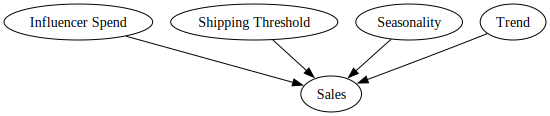

In [17]:
g = gr.Digraph()

g.node(name="Sales", label="Sales")
g.node(name="Influencer Spend", label="Influencer Spend")
g.node(name="Shipping Threshold", label="Shipping Threshold")
g.node(name="Seasonality", label="Seasonality")
g.node(name="Trend", label="Trend")

g.edge(tail_name="Influencer Spend", head_name="Sales")
g.edge(tail_name="Shipping Threshold", head_name="Sales")
g.edge(tail_name="Seasonality", head_name="Sales")
g.edge(tail_name="Trend", head_name="Sales")
g

## Why Marginal Effects Matter: going beyond raw media curves

In Media Mix Models (MMM), we're often interested in understanding how each marketing input—like advertising spend—drives business outcomes. A common way to explore this is by looking at the inferred response curves, such as the saturation curve for media spend. These curves show how total sales respond to increasing investment, accounting for effects like diminishing returns and adstock.

But while these plots are useful, they can be misleading or incomplete when used in isolation.

The reason? Response curves tell you the absolute level of impact across different spend amounts, but they don’t directly tell you the incremental impact of a small change in spend at any given point. This distinction is crucial. For example:
	
* A saturation curve might look steep at low spend levels and flatten out at higher spend—but the exact slope at a specific point (e.g., \$50,000 per week) tells you the real-world payoff of spending an extra \$1,000 right now.
* In cases where multiple inputs are at play (like media spend and pricing changes), response curves for one variable don't show you how interactions or current levels of other variables might affect its marginal impact.

Marginal effects zero in on this slope—the instantaneous rate of change. They answer questions like:
	
* How much additional sales do I gain if I increase influencer spend by 10% next week?
* What's the expected lift if I lower the free shipping threshold by \$5 right now?

These insights are only accessible through marginal effects because they reflect the dynamic, context-sensitive responsiveness of the model:
	
* For media inputs with non-linear transformations (like adstock + saturation), marginal effects show how effectiveness varies across the spend range—revealing whether you're still in the high-ROI zone or have hit diminishing returns.
* For controllable non-media levers (like pricing or shipping policies), marginal effects provide precise, actionable estimates for how tweaks to these levers impact outcomes—even if their overall relationship is more linear.

In other words, while a response curve is like a map of the terrain, marginal effects tell you whether it's worth climbing that next hill. They enable surgical precision in decision-making, ensuring that marketers don't just see where their efforts sit on a curve—but understand whether pushing harder in a particular direction is still worthwhile.

By incorporating marginal effects into MMM outputs, we move from a static understanding of media performance to a dynamic, context-aware view that directly informs resource allocation and strategic adjustments.

## Generate simulated data

In [18]:
def apply_transformations(df, channel, alpha, lam):
    """Apply geometric adstock and saturation transformations."""
    adstocked = geometric_adstock(
        x=df[channel].to_numpy(), alpha=alpha, l_max=8, normalize=True
    ).eval()

    saturated = logistic_saturation(x=adstocked, lam=lam).eval()
    return saturated


def forward_pass(df_in, params):
    """Run predictor variables through the forward pass of the model.

    Given a dataframe with spend data columns and control variables, run this through the
    transformations and return the response variable `y`.
    """
    df = df_in.copy()

    # Apply transformations to channels and calculate y
    df["y"] = params["amplitude"] * (
        df["intercept"]
        + df["trend"]
        + df["seasonality"]
        + sum(
            params["beta"][i]
            * apply_transformations(
                df, params["channels"][i], params["alpha"][i], params["lam"][i]
            )
            for i in range(len(params["channels"]))
        )
        + params["gamma"] * df["shipping_threshold"]  # Include shipping_threshold
        + df["epsilon"]
    )

    return df


df = pd.DataFrame(
    data={
        "date": pd.date_range(
            start=pd.to_datetime("2019-04-01"),
            end=pd.to_datetime("2021-09-01"),
            freq="W-MON",
        )
    }
).assign(
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    dayofyear=lambda x: x["date"].dt.dayofyear,
    t=lambda x: range(x.shape[0]),
)

n_rows = df.shape[0]

# Media data: influencer spend
influencer_spend = rng.uniform(low=0.0, high=1.0, size=n_rows)
df["influencer_spend"] = np.where(
    influencer_spend > 0.9, influencer_spend, influencer_spend / 2
)

# Control variable: shipping threshold
df["shipping_threshold"] = 25.0
df["shipping_threshold"].iloc[-12:] = (
    20.0  # Reduced shipping threshold in the last 12 weeks
)
# Intercept, trend, seasonality components
df["intercept"] = 2.0
df["trend"] = (np.linspace(start=0.0, stop=50, num=n_rows) + 10) ** (1 / 4) - 1
df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

# Noise - can be considered as the effects of unobserved variables upon sales
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n_rows)

params = {
    "channels": ["influencer_spend"],
    "amplitude": 1.0,
    "beta": [3.0],
    "lam": [4.0],
    "alpha": [0.4],
    "gamma": -0.1,  # Weight for shipping_threshold
}

df = forward_pass(df, params)
df.head()

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_47231/1383639638.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["shipping_threshold"].iloc[-12:] = (


,date,year,month,dayofyear,t,influencer_spend,shipping_threshold,intercept,trend,cs,cc,seasonality,epsilon,y
0,2019-04-01,2019,4,91,0,0.918883,25.0,2.0,0.778279,-0.012893,0.006446,-0.003223,-0.118826,2.561363
1,2019-04-08,2019,4,98,1,0.230898,25.0,2.0,0.795664,0.225812,-0.113642,0.056085,0.064977,2.264874
2,2019-04-15,2019,4,105,2,0.254486,25.0,2.0,0.812559,0.451500,-0.232087,0.109706,-0.020269,1.998208
3,2019-04-22,2019,4,112,3,0.035995,25.0,2.0,0.828993,0.651162,-0.347175,0.151993,0.400209,1.701116
4,2019-04-29,2019,4,119,4,0.336013,25.0,2.0,0.844997,0.813290,-0.457242,0.178024,0.057609,2.003646


<Axes: >

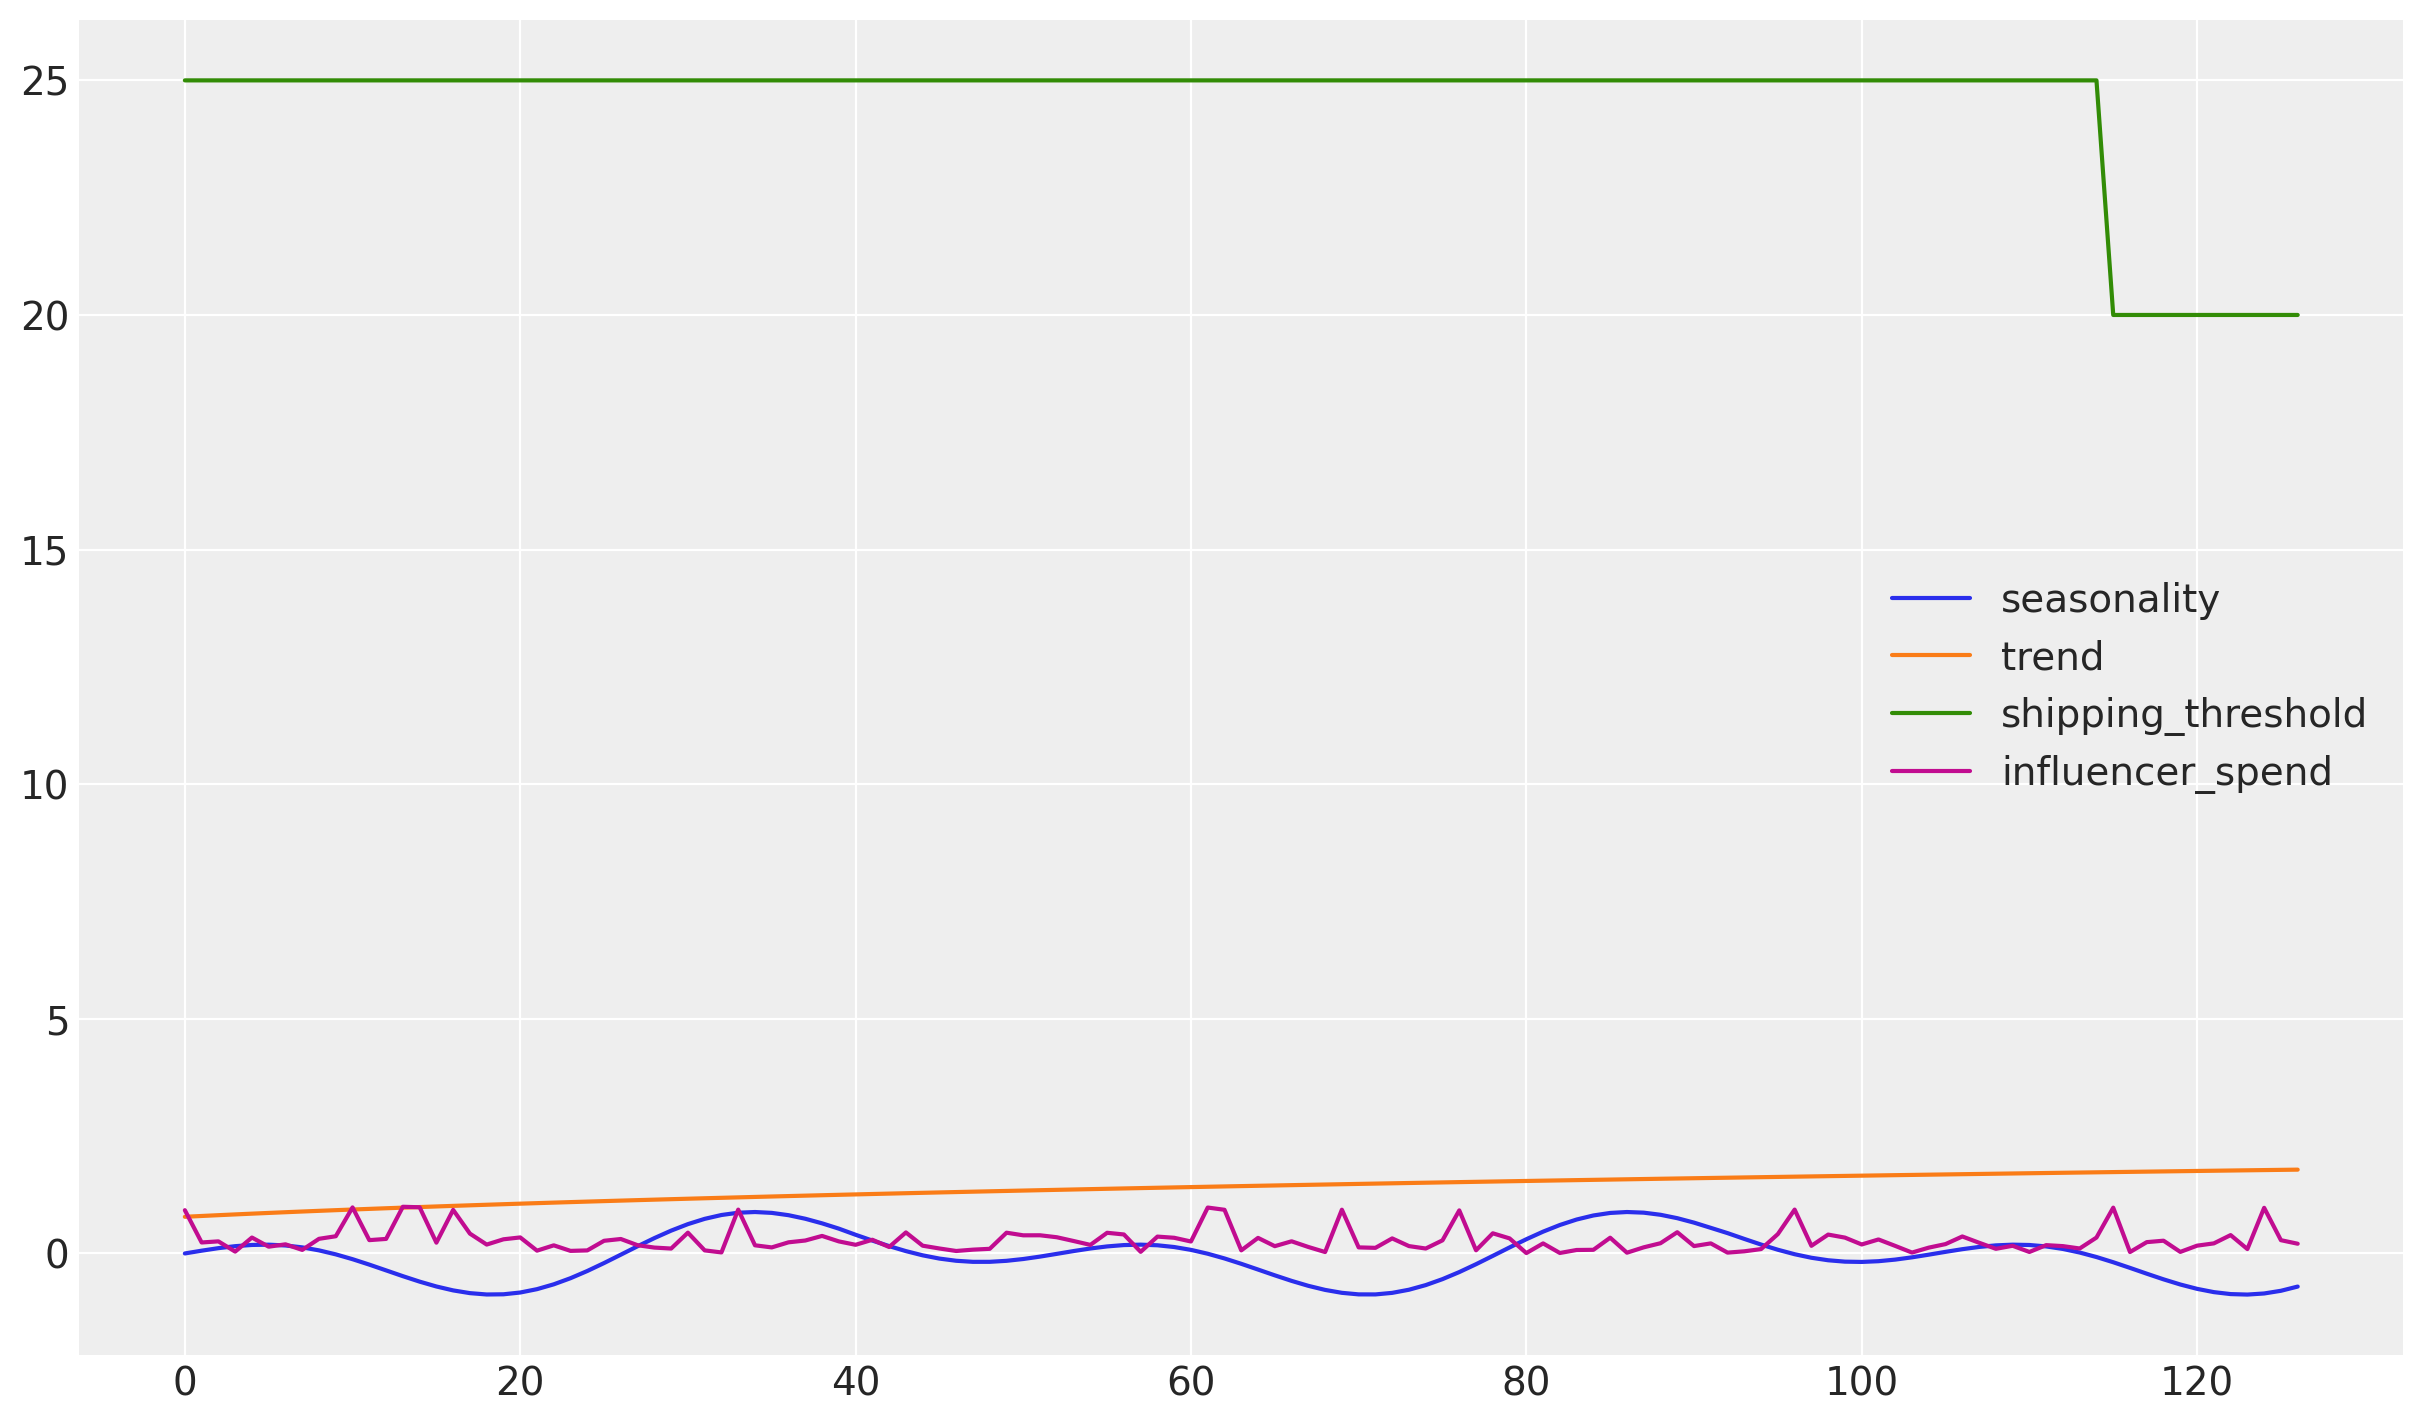

In [19]:
df[["seasonality", "trend", "shipping_threshold", "influencer_spend"]].plot()

## Build and fit the MMM

In [20]:
mmm = MMM(
    date_column="date",
    target_column="y",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["influencer_spend"],
    control_columns=["t", "shipping_threshold"],
    yearly_seasonality=2,
)

x_train = df.drop(columns=["y"])
y_train = df["y"]

mmm.fit(X=x_train, y=y_train)
mmm.sample_posterior_predictive(x_train, extend_idata=True);

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Sampling: [y]


Output()

## Marginal effects

### TODO

- [ ] Explain the `CounterfactualSweep` class. The sweep values and what the sweep_type does

In [21]:
# Absolute Sweep Example - influencer_spend

sweep_values = np.linspace(0, 2, 12)  # Set spend directly from 0 to $100k
sweep = CounterfactualSweep(
    mmm=mmm,
    X=x_train,
    predictors=["influencer_spend"],
    sweep_values=sweep_values,
    sweep_type="absolute",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


<Axes: title={'center': 'Marginal effects plot'}, xlabel="Absolute value of: ['influencer_spend']", ylabel='Marginal effect (dE[Y]/dX)'>

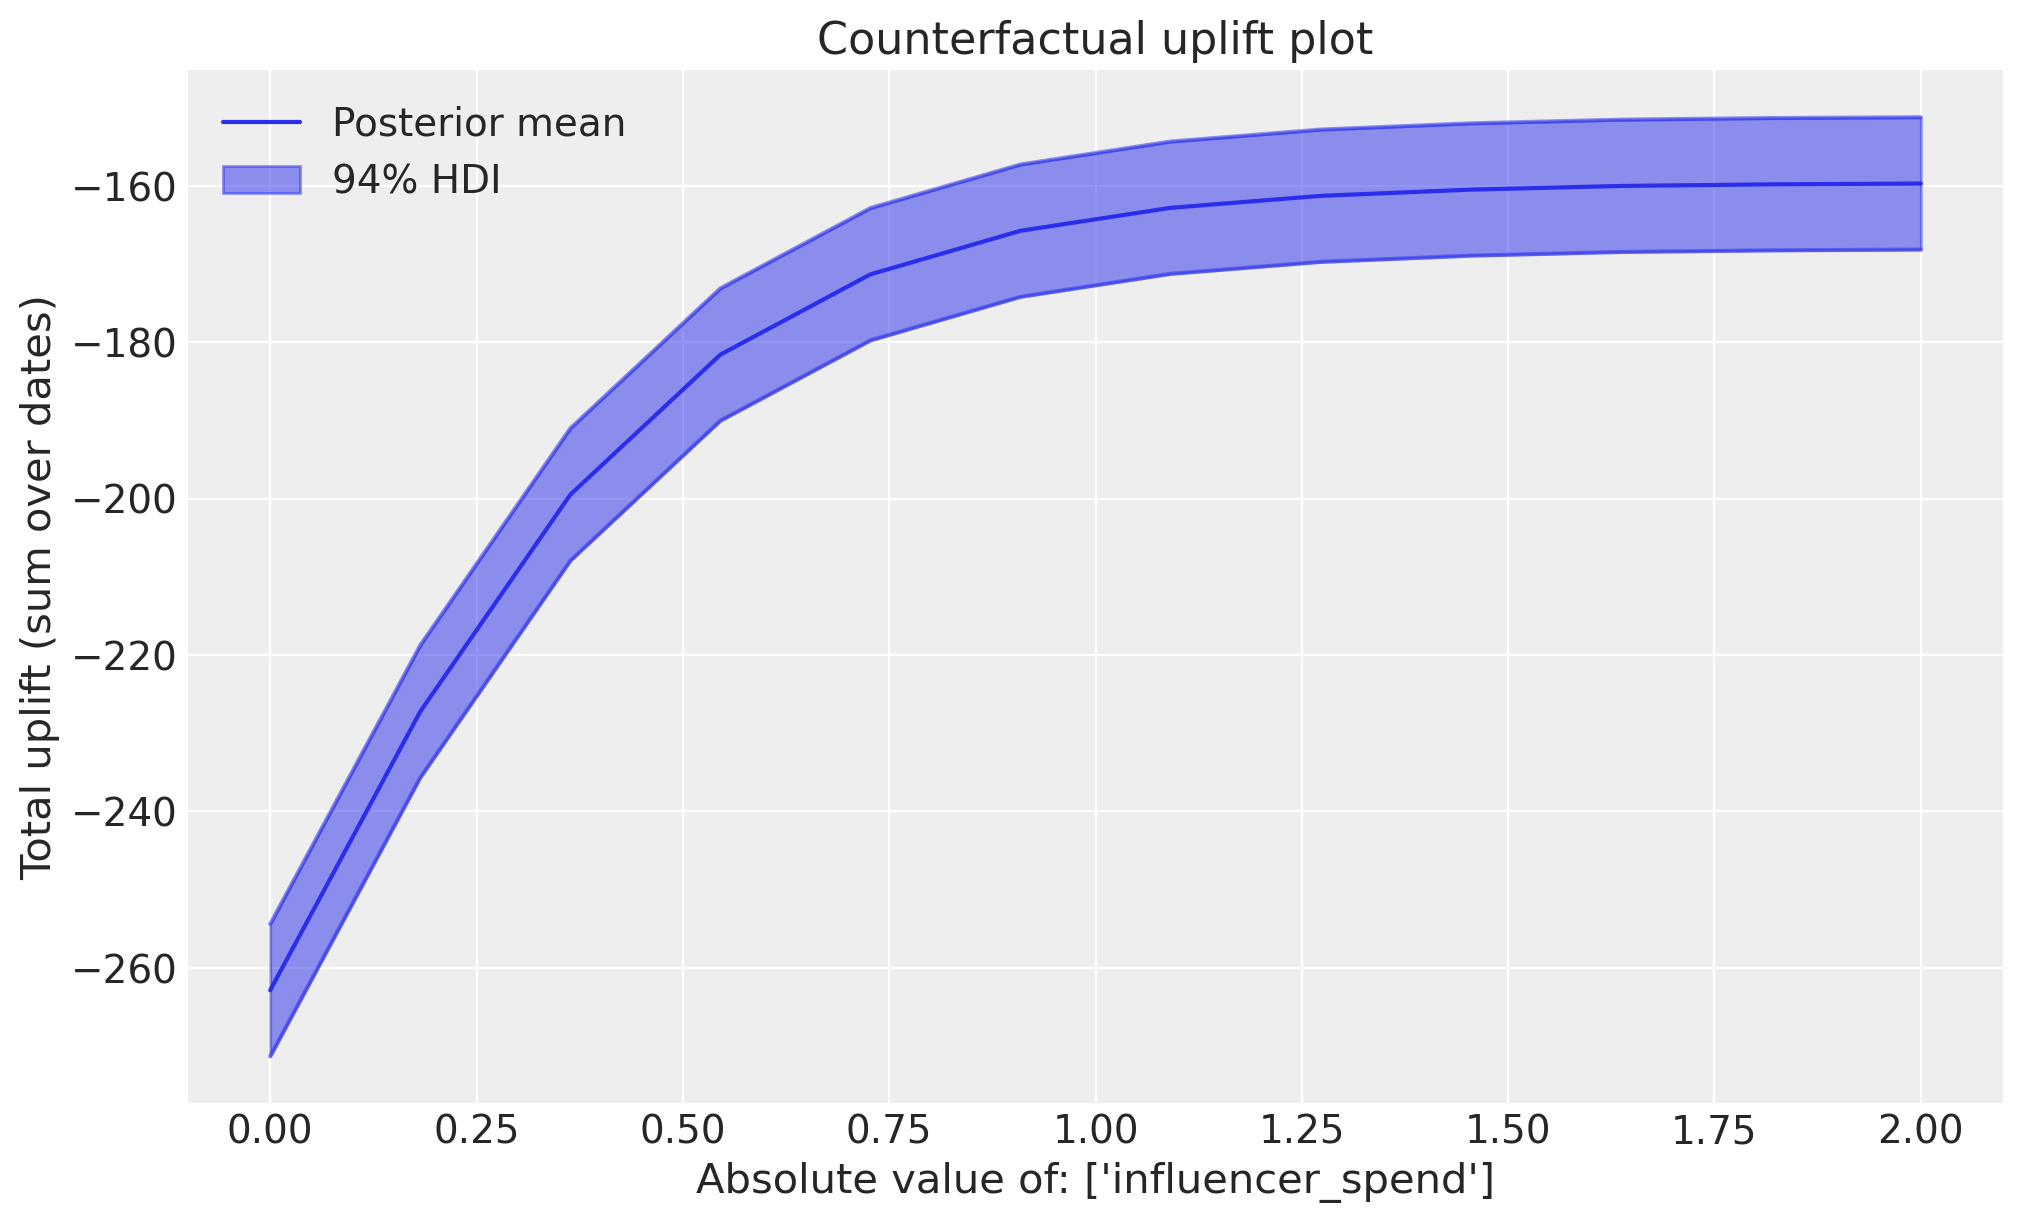

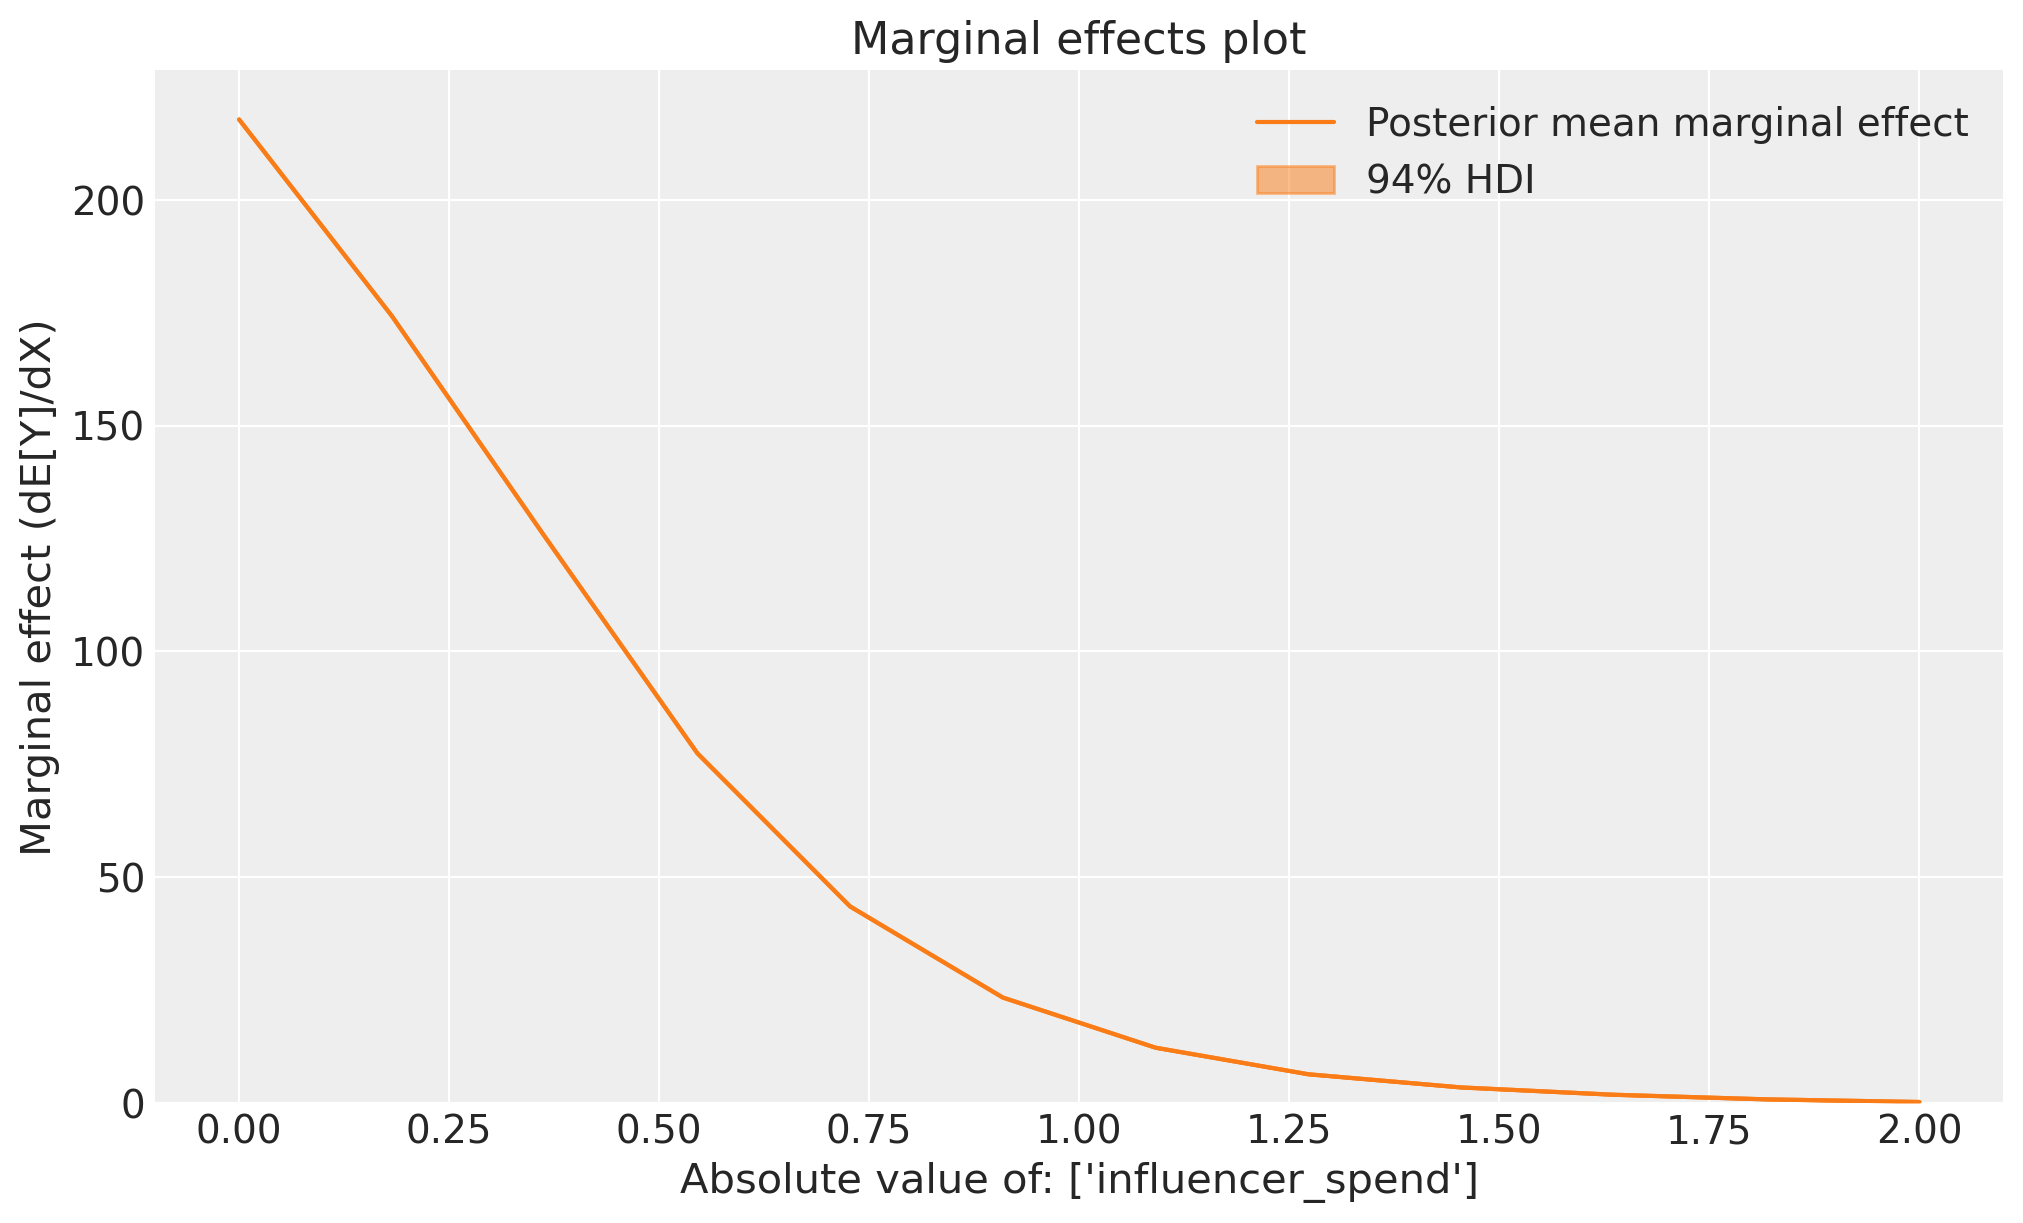

In [22]:
sweep.plot_uplift()
sweep.plot_marginal_effects()

TODO: explain the figures

In [24]:
# Absolute Sweep Example - influencer_spend

sweep = CounterfactualSweep(
    mmm=mmm,
    X=x_train,
    predictors=["shipping_threshold"],
    sweep_values=np.linspace(0, 50, 5),
    sweep_type="absolute",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


<Axes: title={'center': 'Marginal effects plot'}, xlabel="Absolute value of: ['shipping_threshold']", ylabel='Marginal effect (dE[Y]/dX)'>

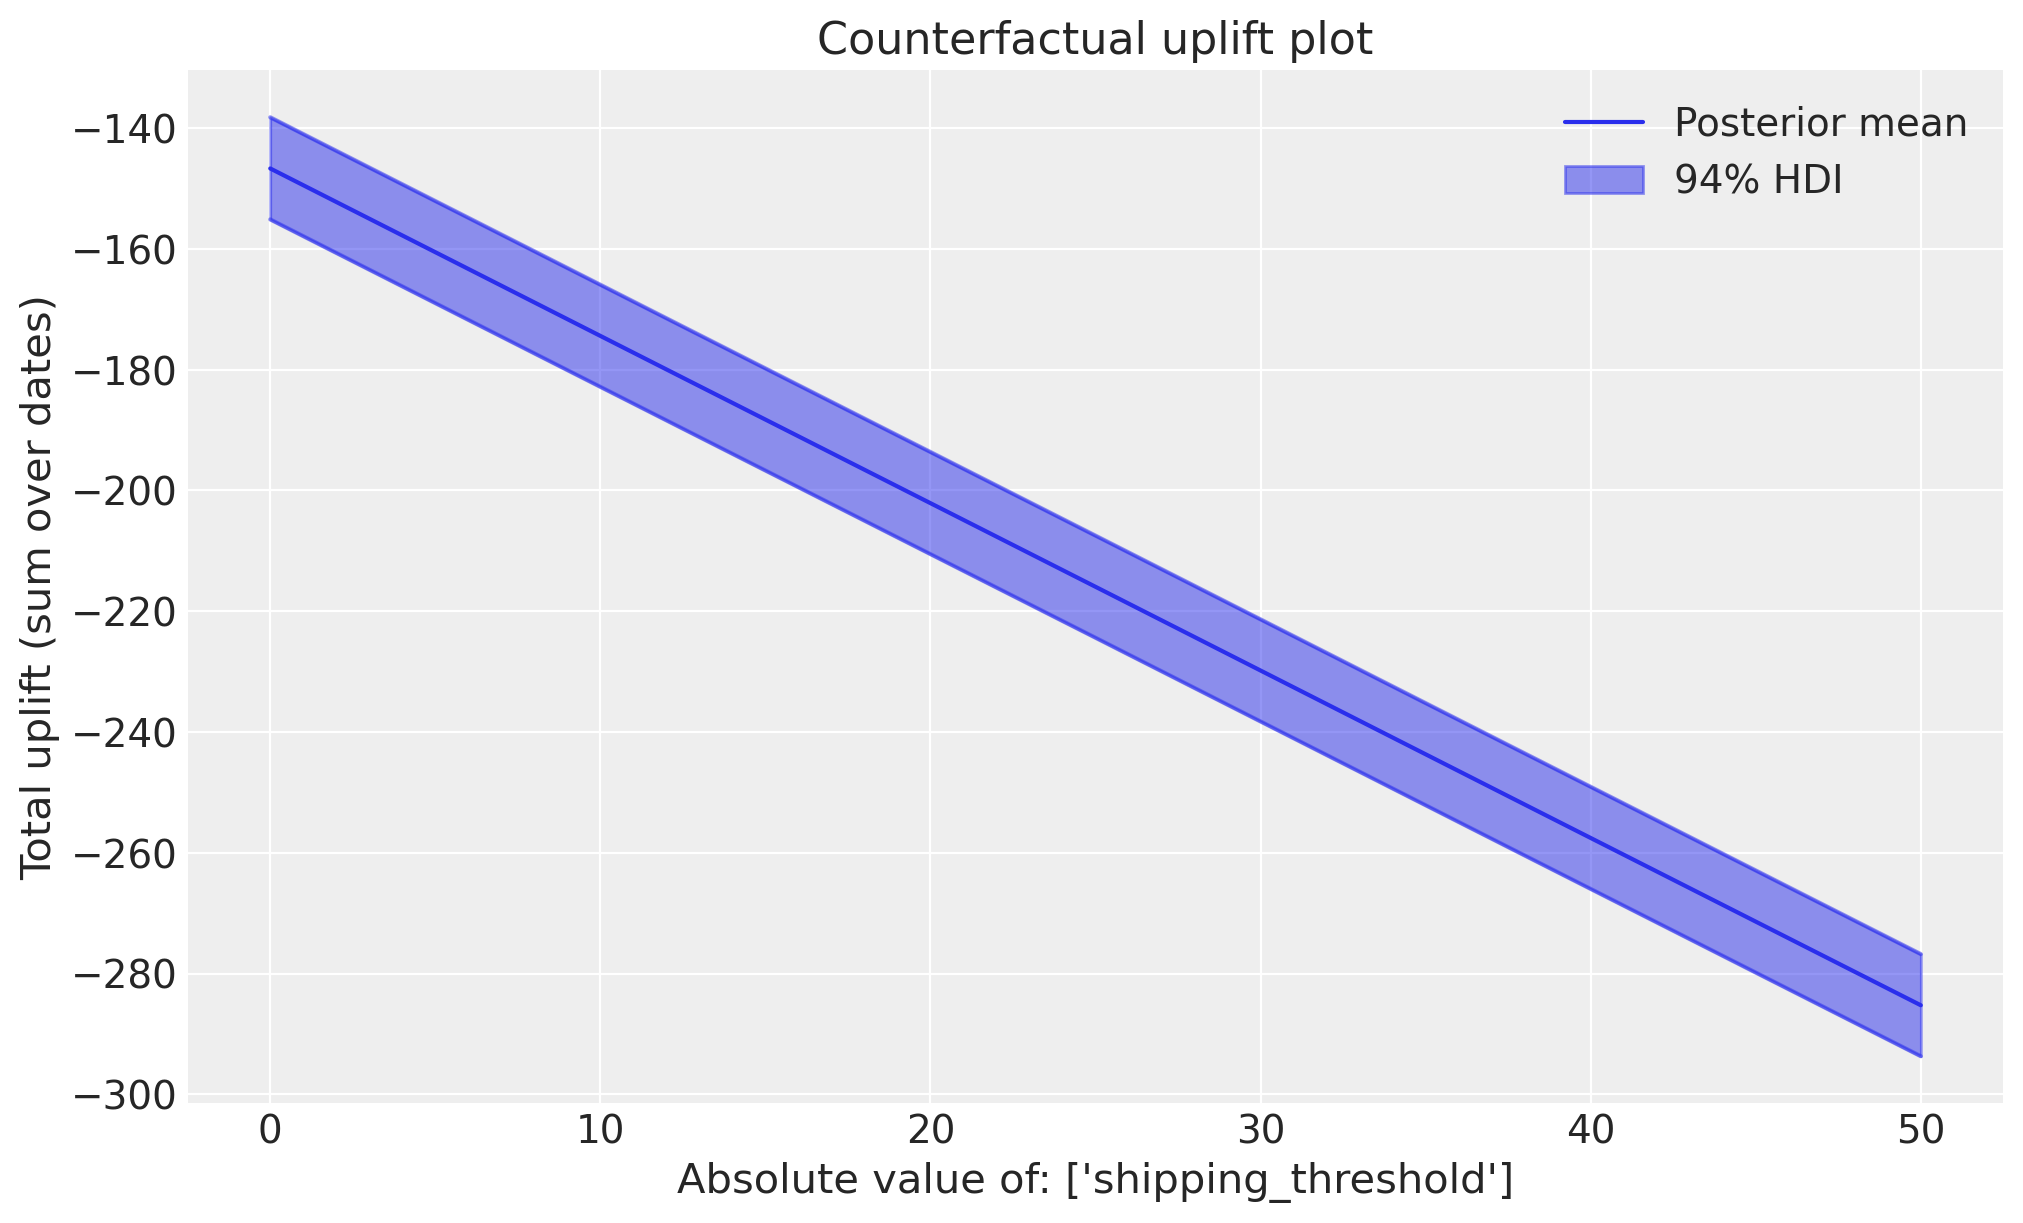

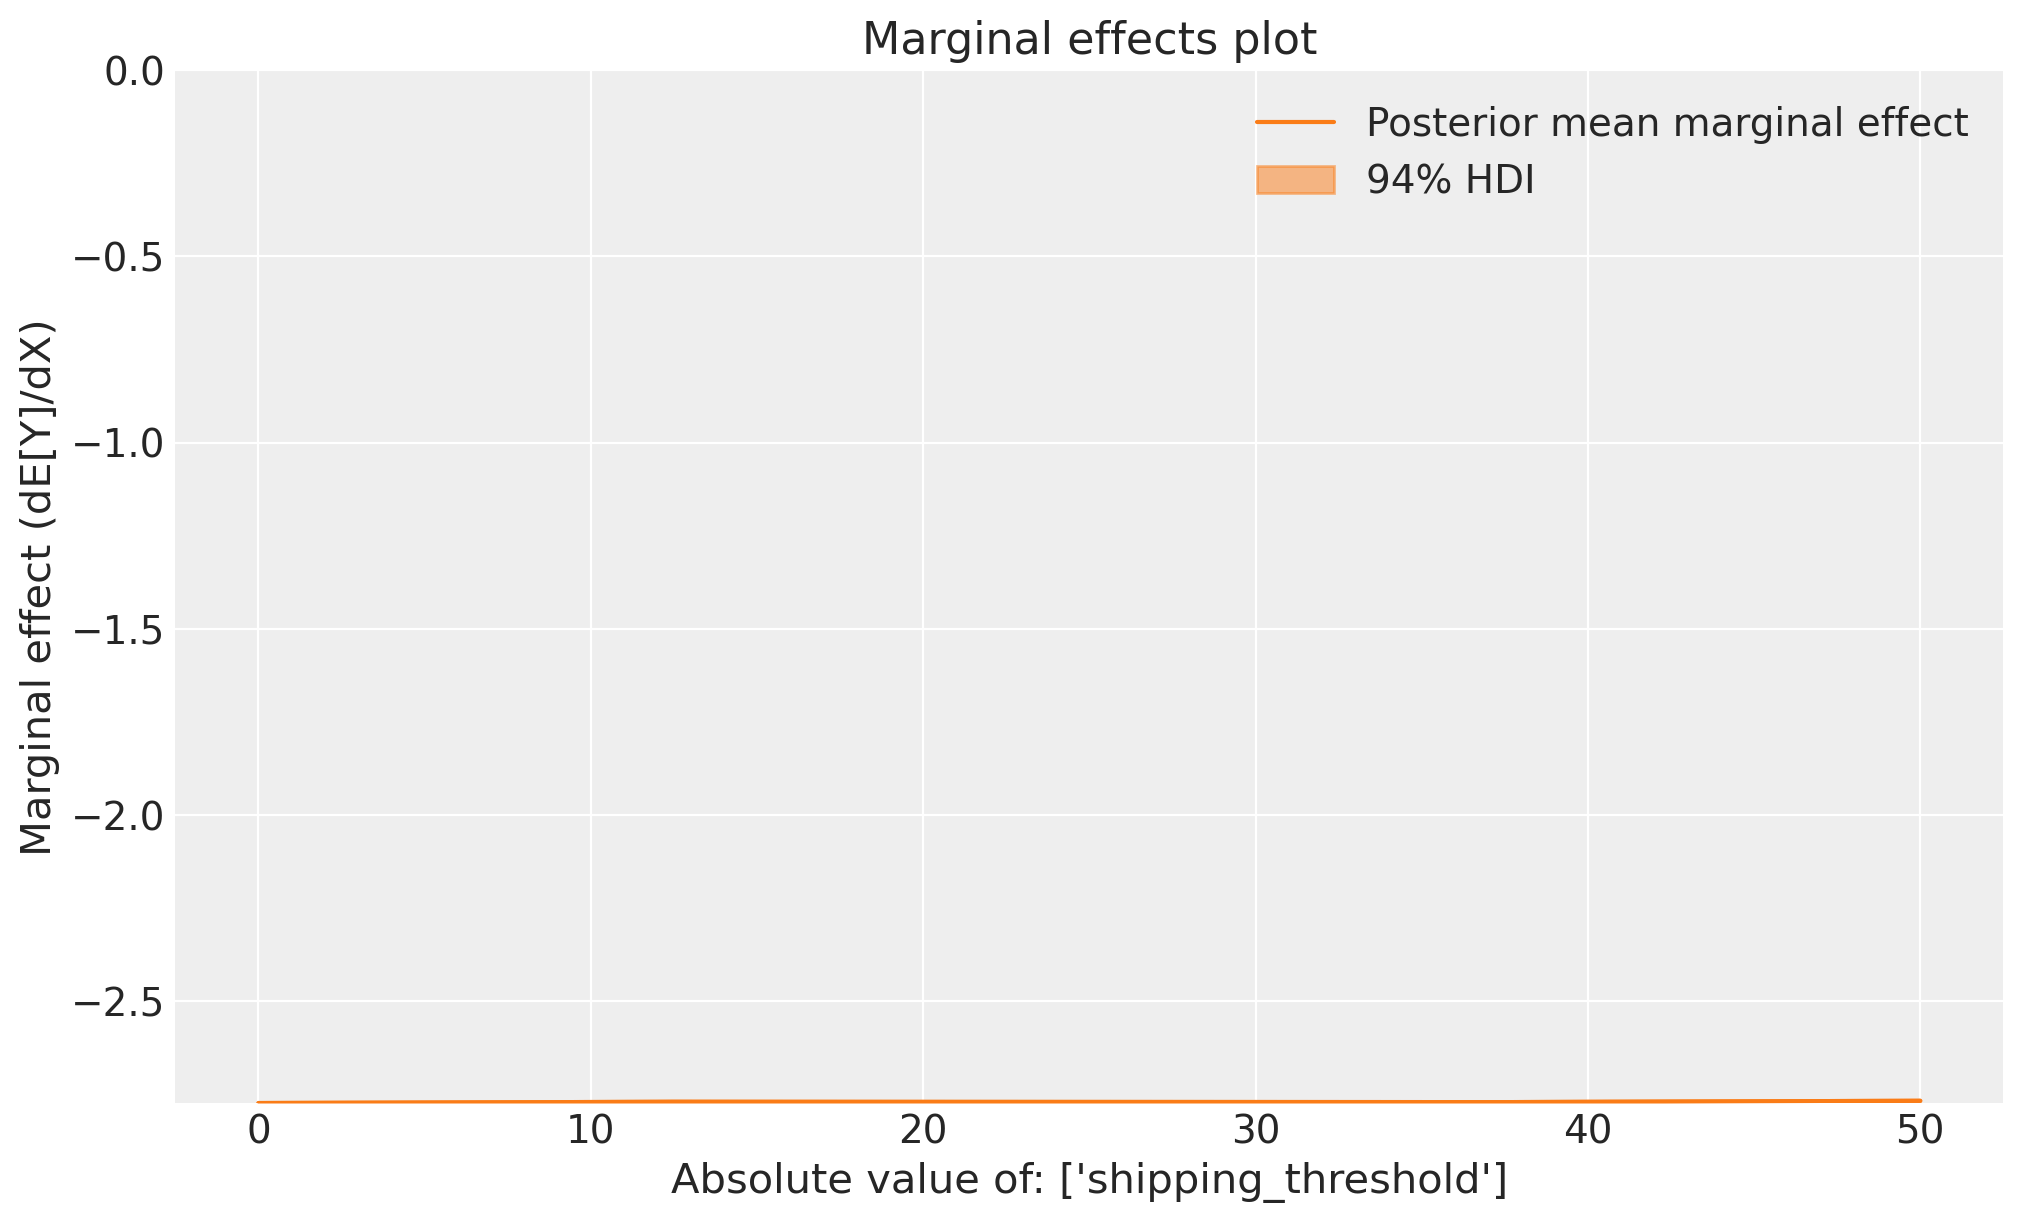

In [25]:
sweep.plot_uplift()
sweep.plot_marginal_effects()

TODO: explain the figures

## Counterfactual sweep - multiplicative

In [26]:
# Multiplicative Sweep Example

sweep_values = np.linspace(0.0, 2.0, 10)  # 0% to 200% of current spend
sweep = CounterfactualSweep(
    mmm=mmm,
    X=x_train,
    predictors=["influencer_spend"],
    sweep_values=sweep_values,
    sweep_type="multiplicative",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


<Axes: title={'center': 'Marginal effects plot'}, xlabel="Multiplicative change of: ['influencer_spend']", ylabel='Marginal effect (dE[Y]/dX)'>

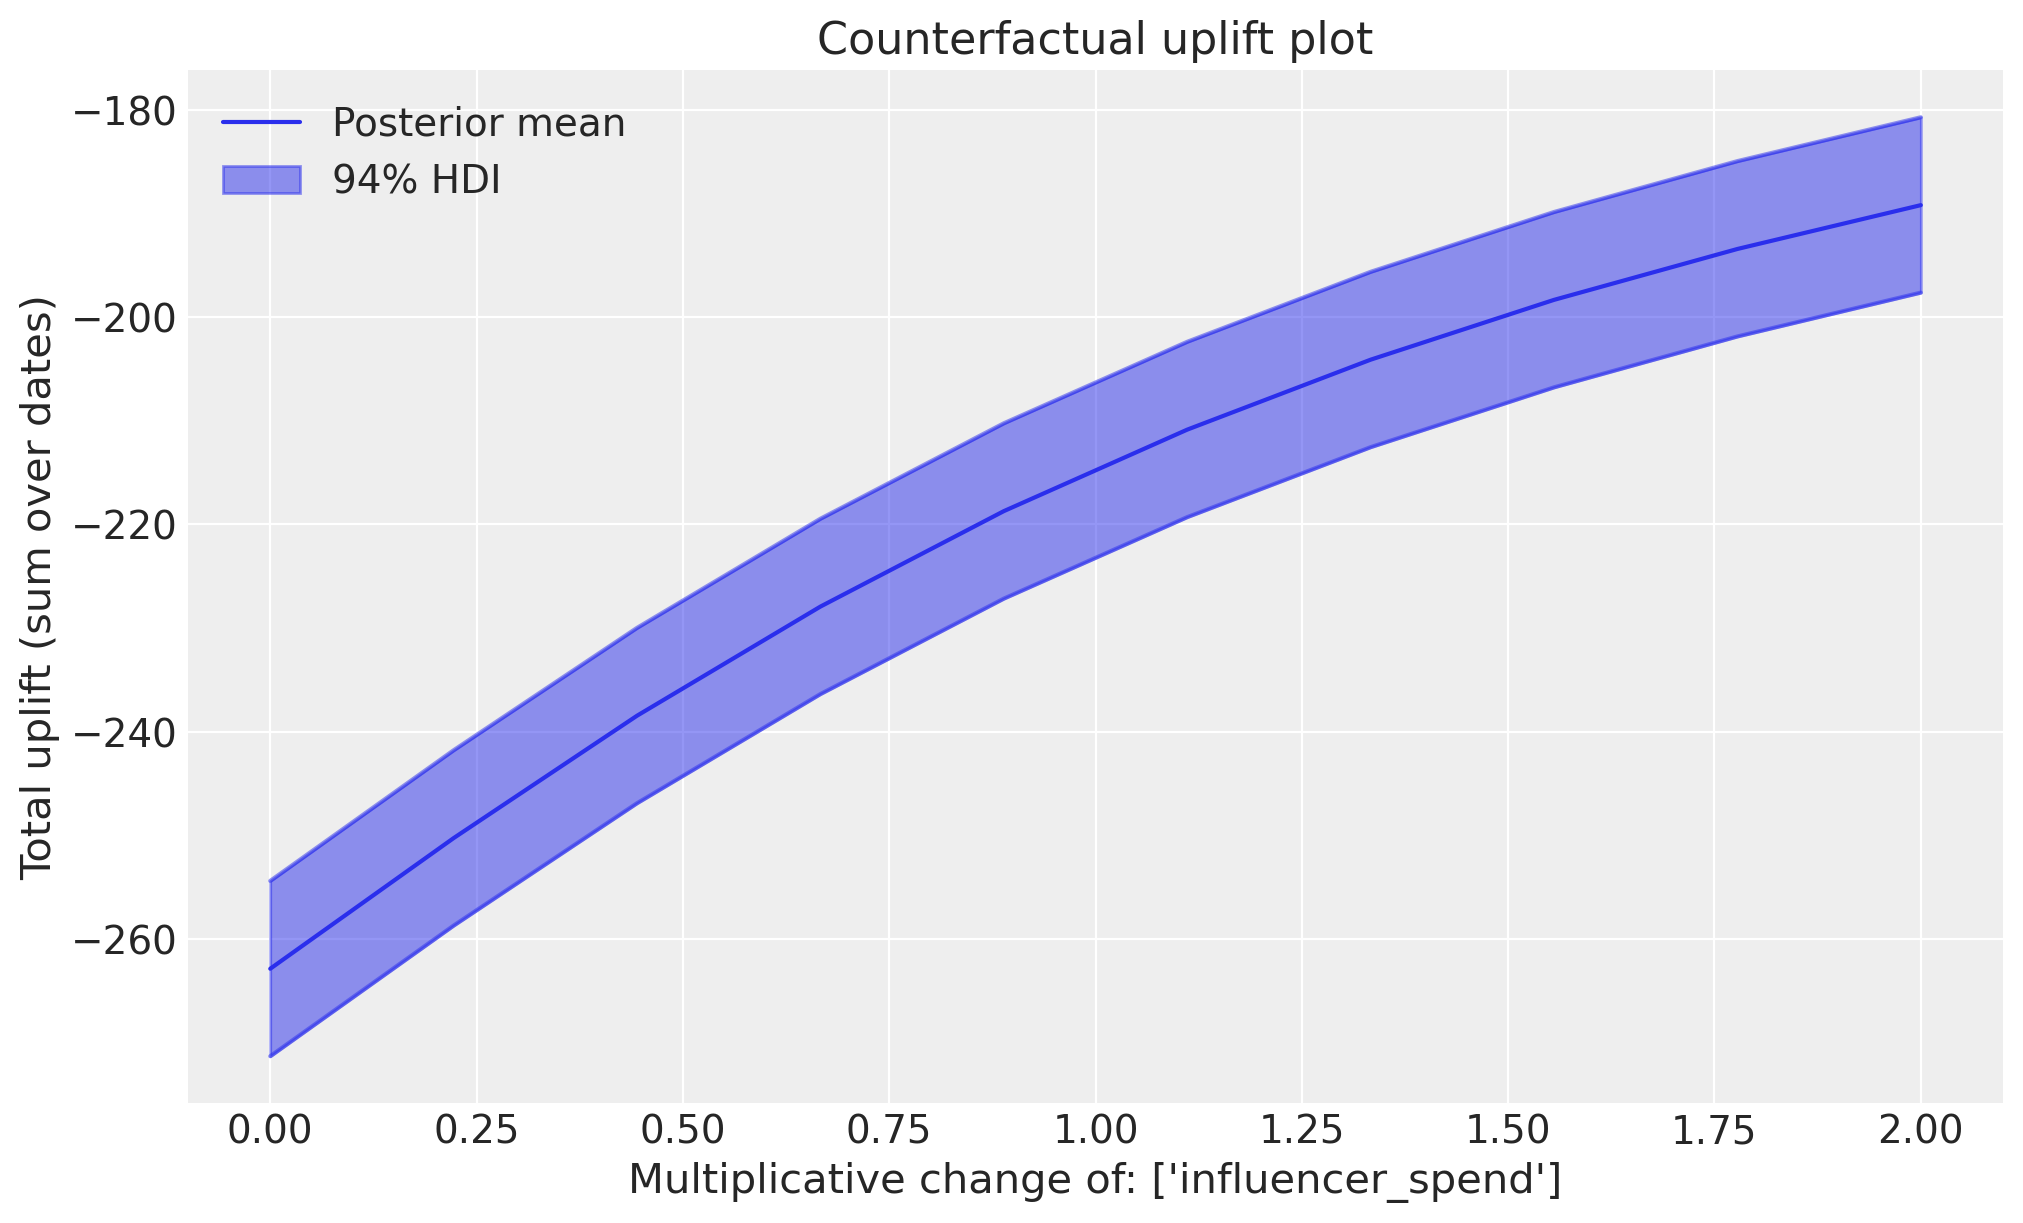

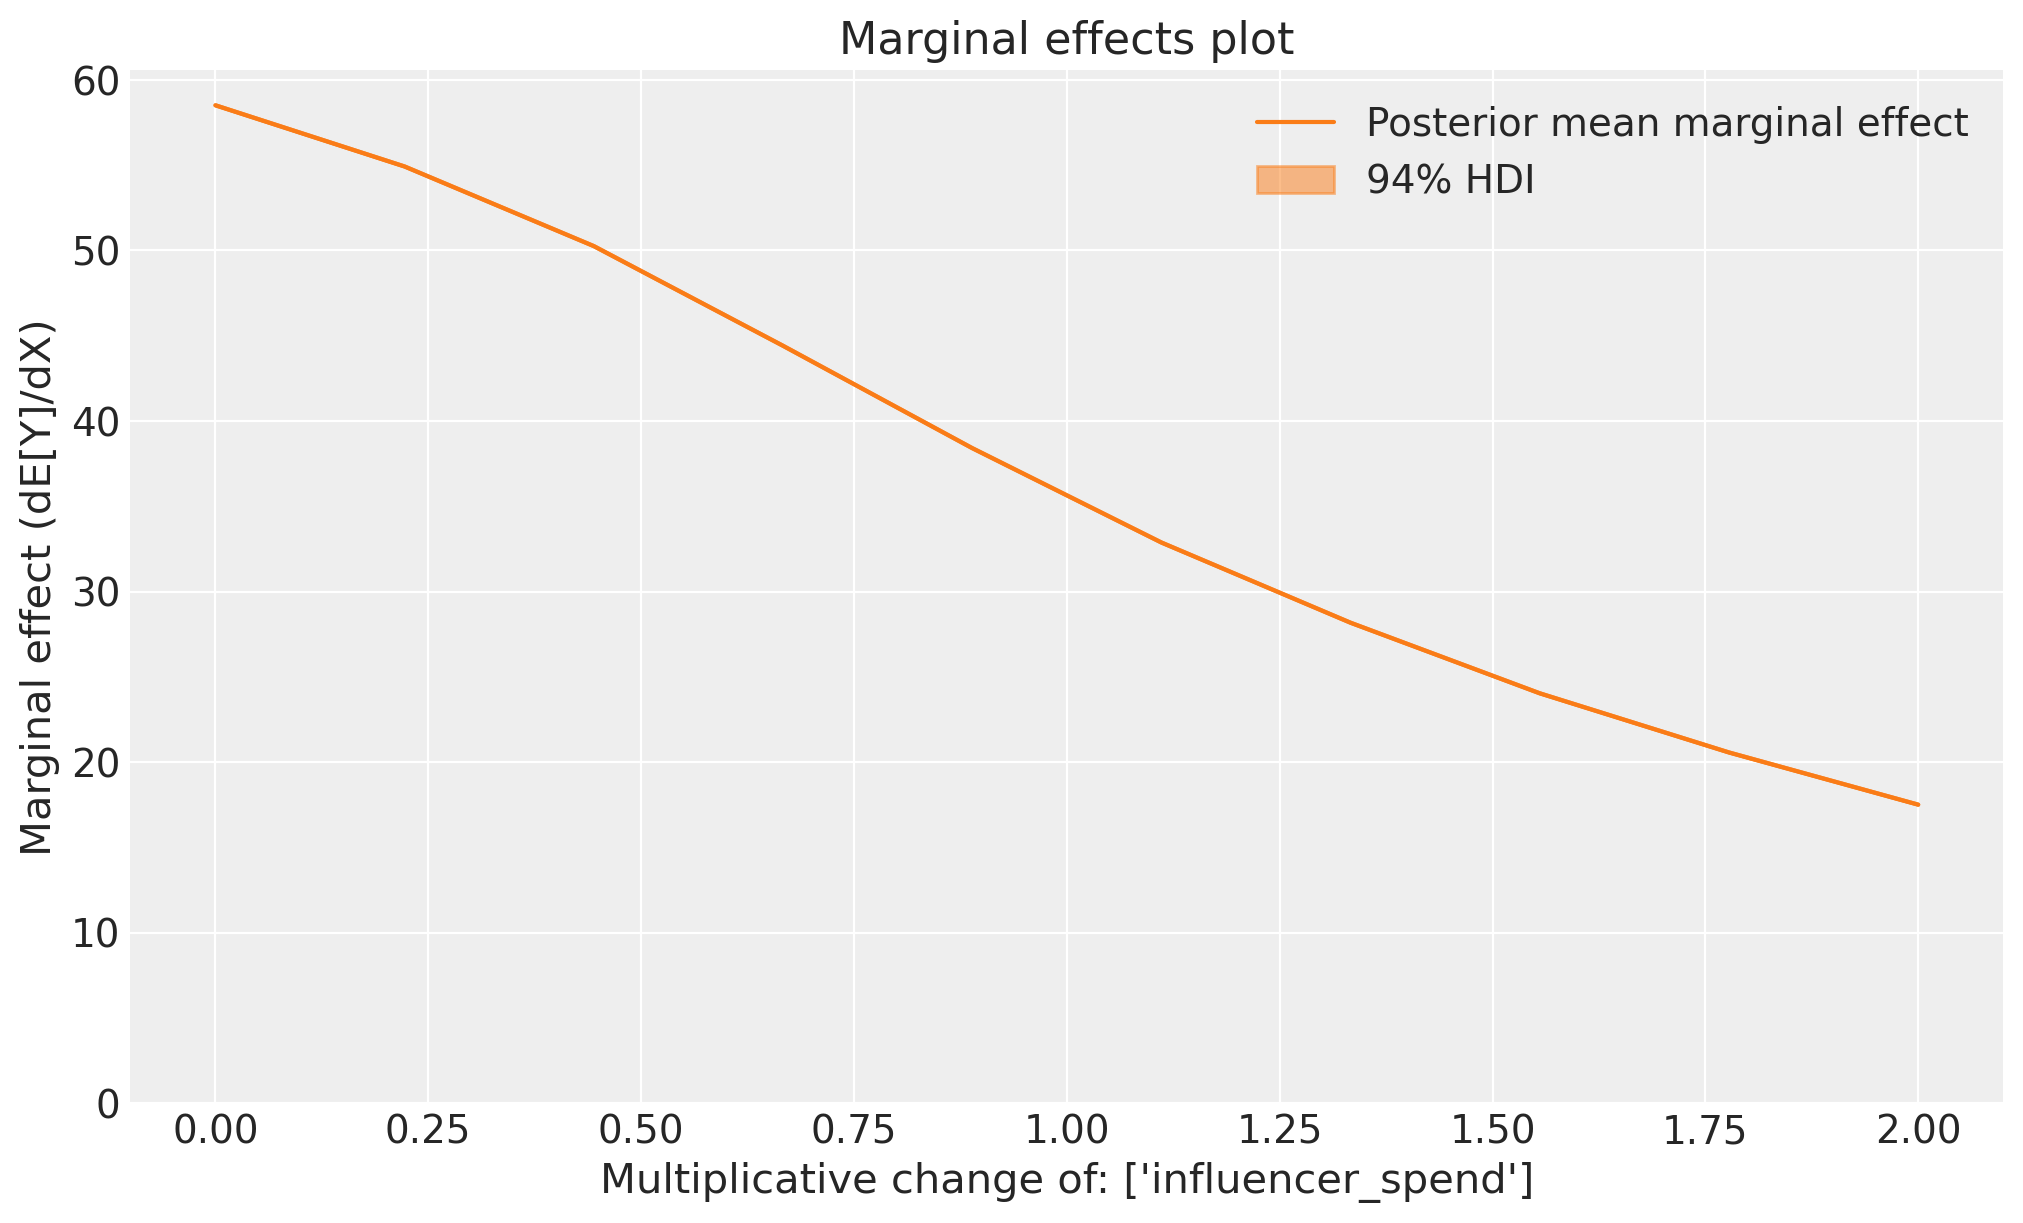

In [27]:
sweep.plot_uplift()
sweep.plot_marginal_effects()

TODO: explain the figures

## Counterfactual sweep - additive

In [28]:
# Additive Sweep Example
sweep = CounterfactualSweep(
    mmm=mmm,
    X=x_train,
    predictors=["influencer_spend"],
    sweep_values=np.arange(0, 2, 0.2),
    sweep_type="additive",
)

Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]
Sampling: [y]


<Axes: title={'center': 'Marginal effects plot'}, xlabel="Additive change of: ['influencer_spend']", ylabel='Marginal effect (dE[Y]/dX)'>

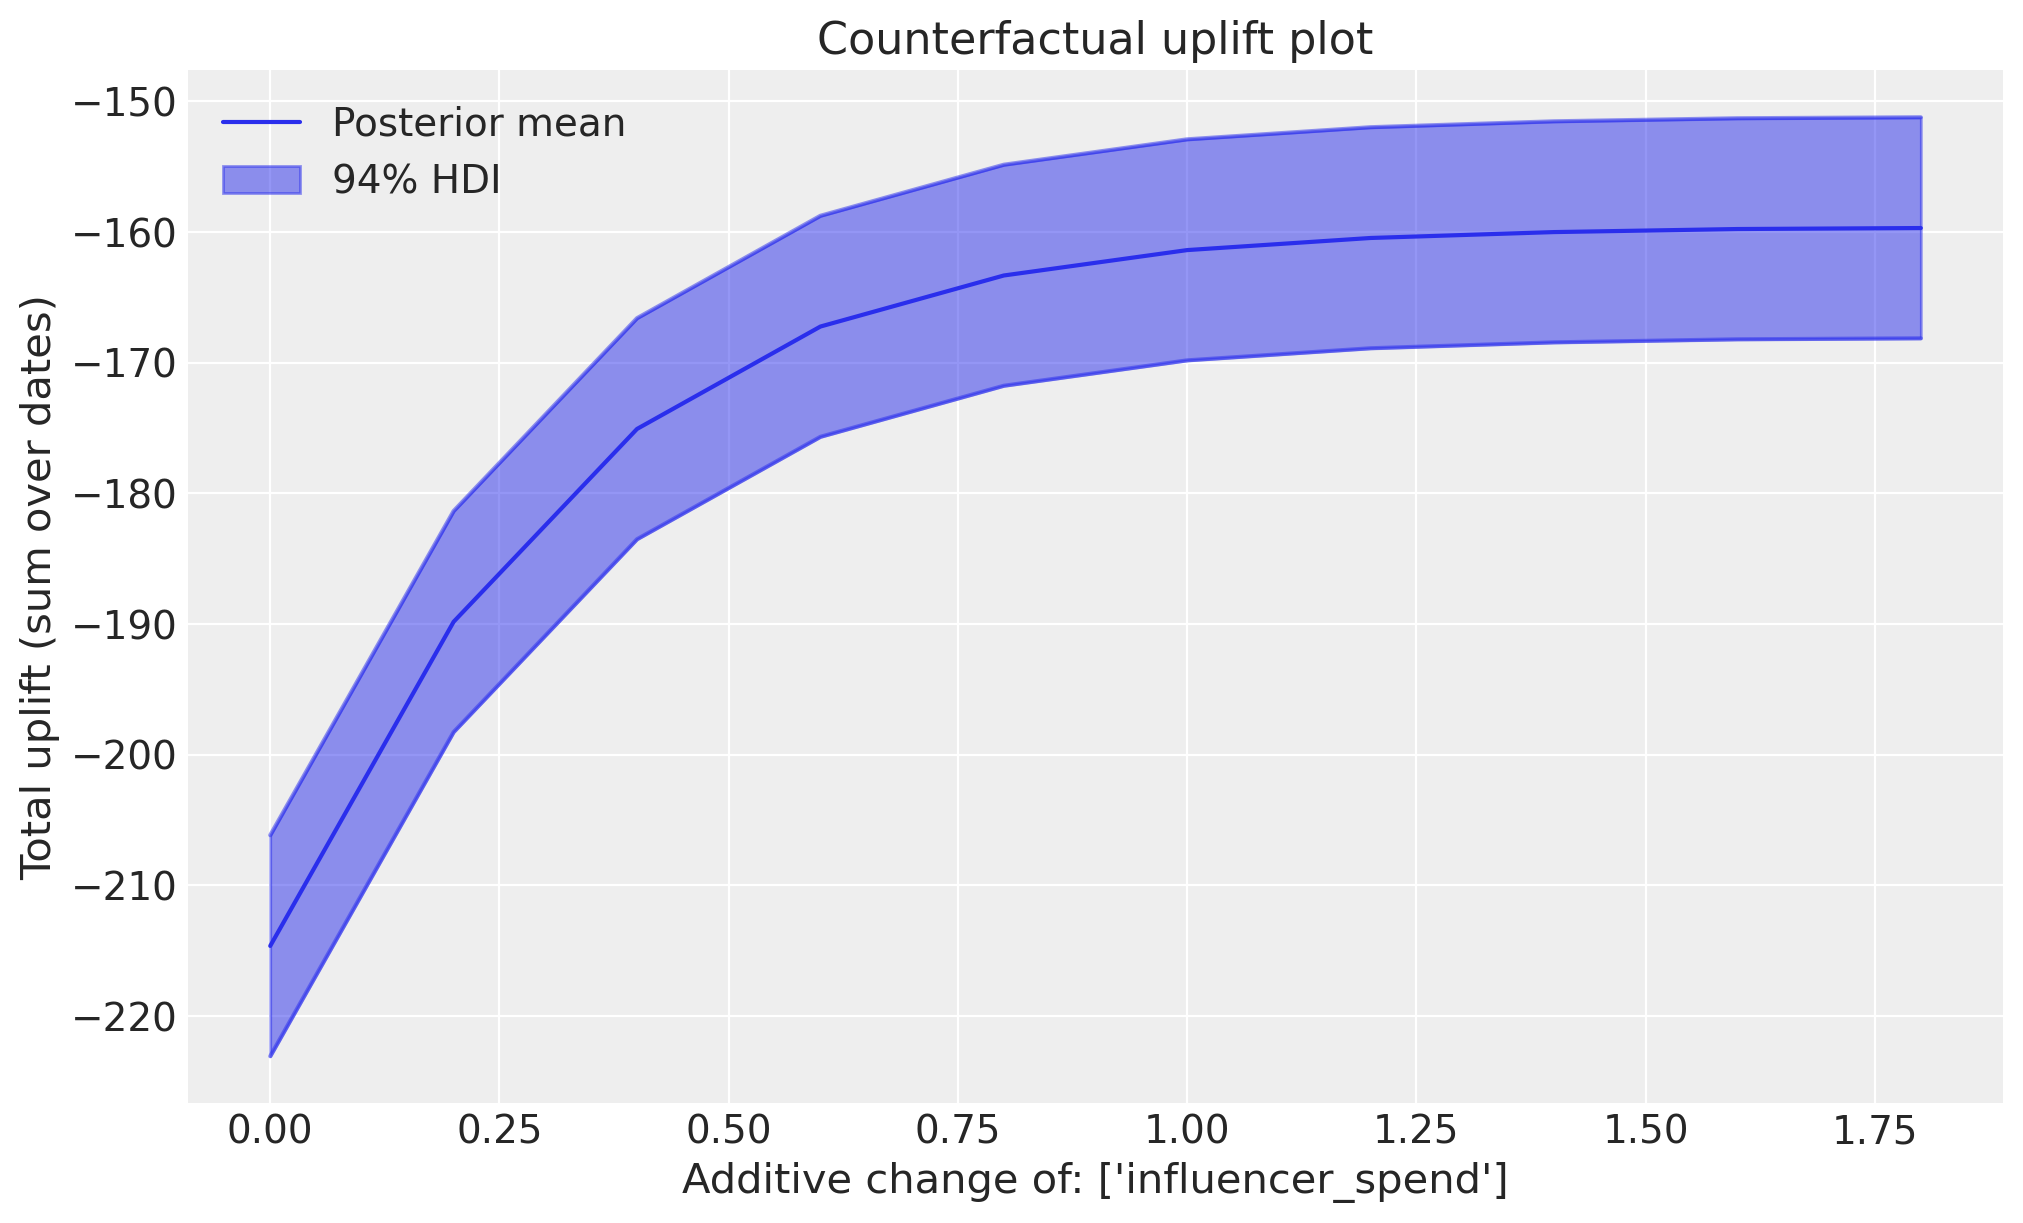

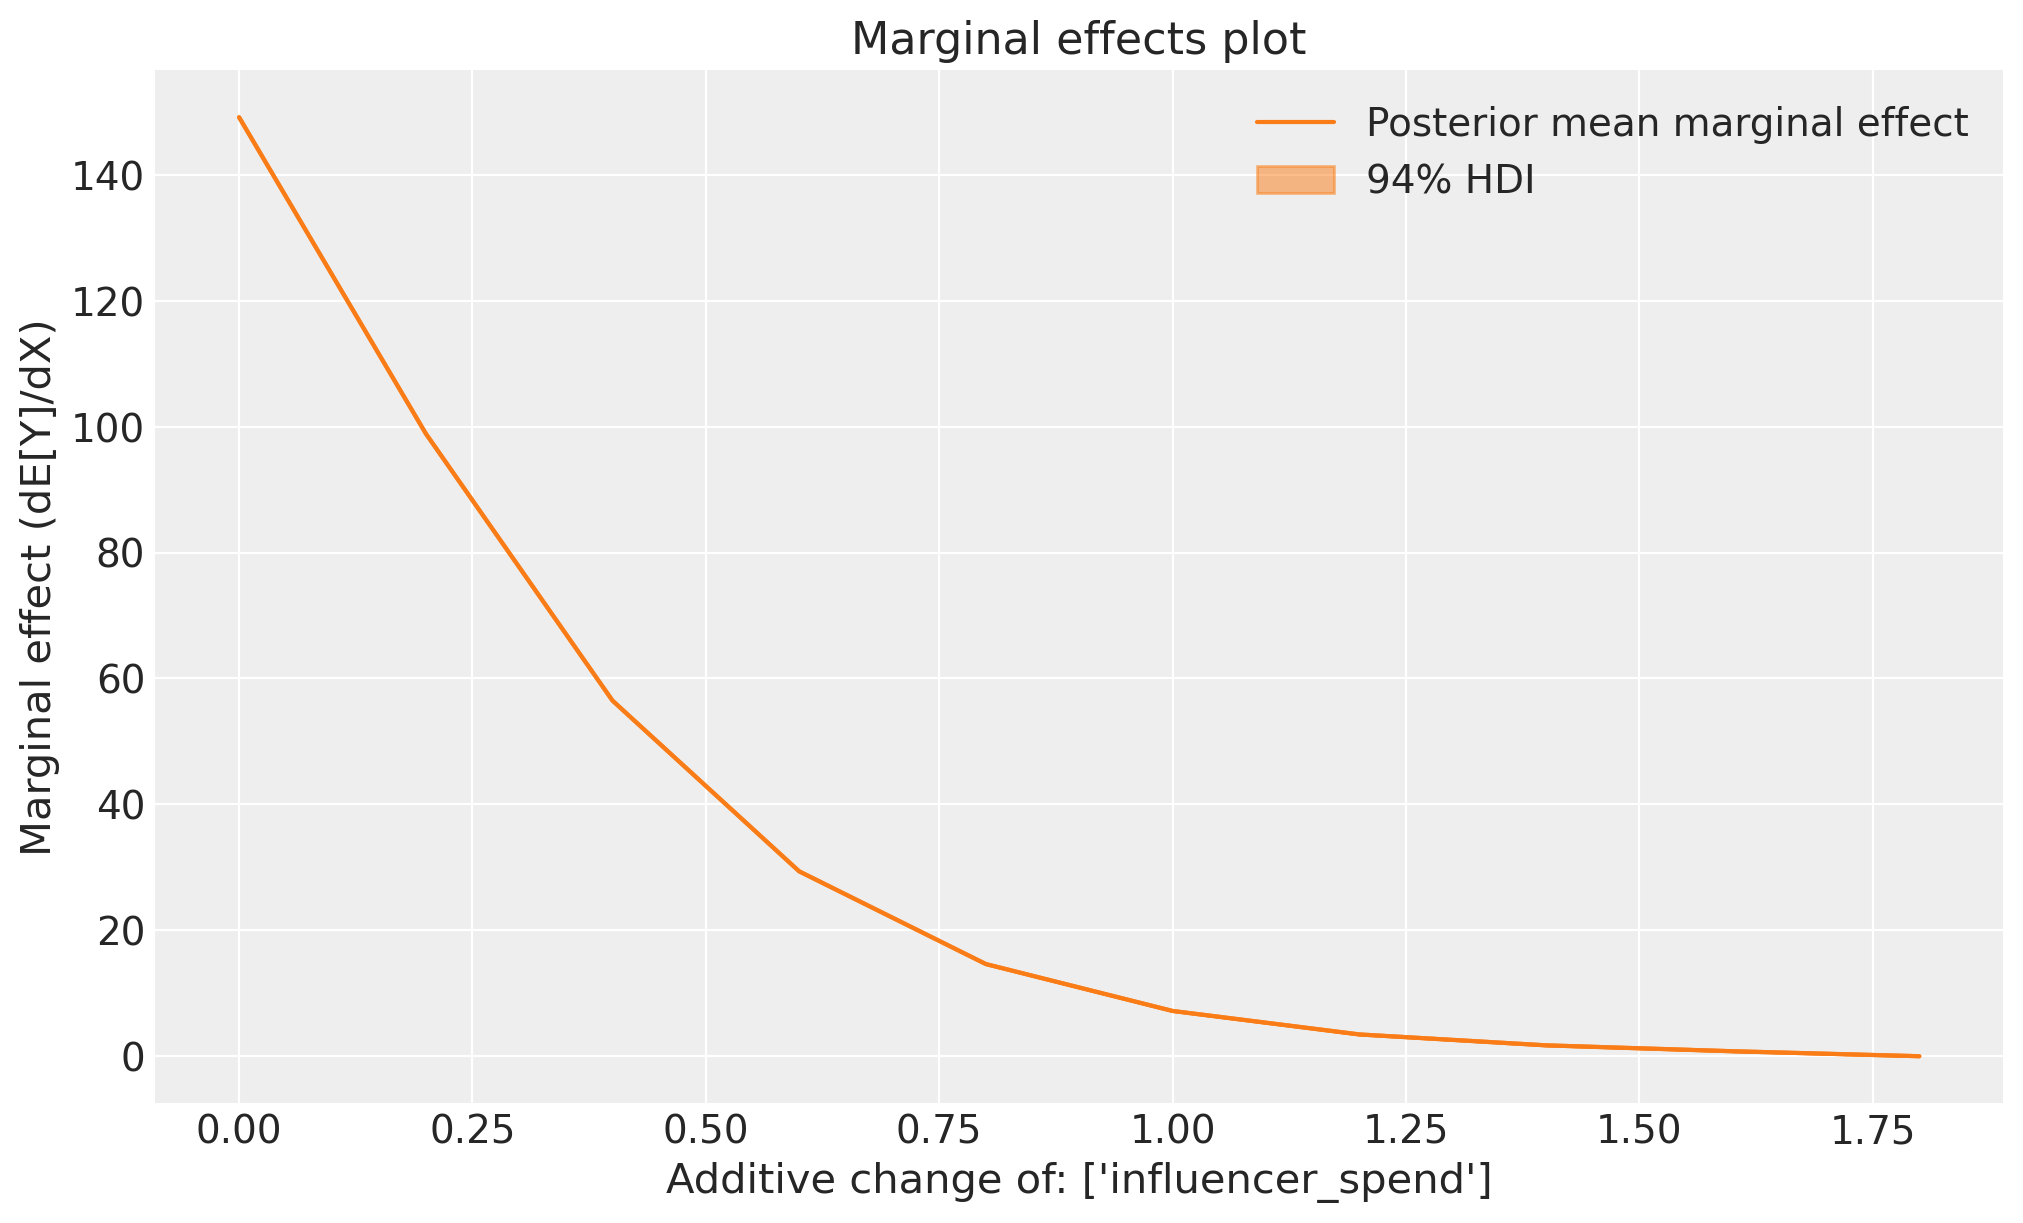

In [29]:
sweep.plot_uplift()
sweep.plot_marginal_effects()

TODO: explain the figures

## Summary

##

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu May 15 2025

Python implementation: CPython
Python version       : 3.10.17
IPython version      : 8.36.0

pymc_marketing: 0.13.1
pytensor      : 2.30.3

matplotlib    : 3.10.1
pymc_marketing: 0.13.1
pandas        : 2.2.3
numpy         : 1.26.4
graphviz      : 0.20.3
arviz         : 0.21.0

Watermark: 2.5.0

